# Ejemplo VAE

Implementación de Variational Auto-Enconder (VAE) tomado de la documentación de TensorFlow para MNIST (tomada del ejemplo):

https://www.tensorflow.org/guide/keras/custom_layers_and_models

**Implementación alternativa a POO**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Lambda
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [0]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
original_dim = 784
intermediate_dim = 64
latent_dim = 32

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

epochs = 3

# Encoder
original_inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(original_inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs=original_inputs, outputs=z, name='encoder')

# Final encoder
encoder.summary()


11493376/11490434 [==============================] - 1s 0us/step
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           50240       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 32)           2080        dense[0][0]                      
___________________________

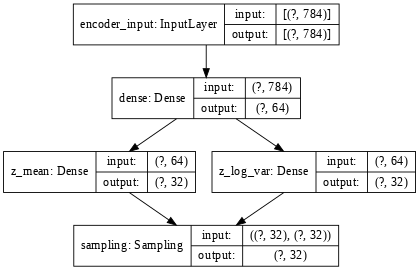

In [4]:
plot_model(encoder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64)

In [0]:
# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(inputs=latent_inputs, outputs=outputs, name='decoder')

In [6]:
# Final encoder
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               50960     
Total params: 53,072
Trainable params: 53,072
Non-trainable params: 0
_________________________________________________________________


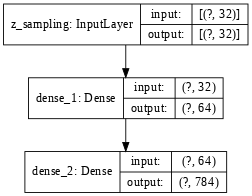

In [7]:
plot_model(decoder, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64)

In [0]:
# Modelo VAE
outputs = decoder(z)
vae = Model(inputs=original_inputs, outputs=outputs, name='vae')

In [9]:
# Final encoder
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           50240       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 32)           2080        dense[0][0]                      
________________________________________________________________________________________________

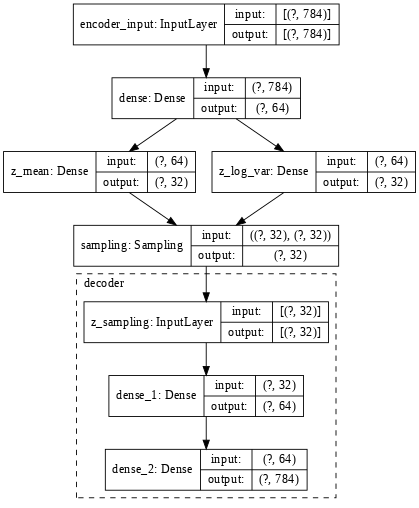

In [10]:
plot_model(vae, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64)

In [6]:
# Add KL divergence regularization loss.
kl_loss = - 0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae.add_loss(kl_loss)

# Train.
optimizer = Adam(learning_rate=1e-3)
vae.compile(optimizer, loss = MeanSquaredError(), metrics=['accuracy'])
vae.fit(x_train, x_train, epochs=epochs, batch_size=64)

Epoch 1/3
938/938 [==============================] - 3s 3ms/step - loss: 0.0745 - accuracy: 0.0095
Epoch 2/3
938/938 [==============================] - 3s 3ms/step - loss: 0.0676 - accuracy: 0.0099
Epoch 3/3
938/938 [==============================] - 3s 3ms/step - loss: 0.0676 - accuracy: 0.0110


In [0]:
# z_samples = np.zeros((n_points, latent_len))
# decoder.predict(train_dataset) # falta arreglar esto